In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import joblib
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, roc_auc_score

from src.data import getAbsolute, resampling, explore_dataset as ex
from src.features import kpw_build_features, standardization, clustering
from src.models import cross_validation, save_predictions, blending, eval_model
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
import xgboost as xgb
from scipy.spatial import distance
from yellowbrick.cluster import KElbowVisualizer


## Explore Data

Understand the training set and test set, and what issues there are to determine what data preparation steps are required.

In [2]:
ex.explore("train.csv")

=== dataframe info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-nul

In [3]:
ex.explore("test.csv")

=== dataframe info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id_old   3799 non-null   int64  
 1   Id       3799 non-null   int64  
 2   GP       3799 non-null   int64  
 3   MIN      3799 non-null   float64
 4   PTS      3799 non-null   float64
 5   FGM      3799 non-null   float64
 6   FGA      3799 non-null   float64
 7   FG%      3799 non-null   float64
 8   3P Made  3799 non-null   float64
 9   3PA      3799 non-null   float64
 10  3P%      3799 non-null   float64
 11  FTM      3799 non-null   float64
 12  FTA      3799 non-null   float64
 13  FT%      3799 non-null   float64
 14  OREB     3799 non-null   float64
 15  DREB     3799 non-null   float64
 16  REB      3799 non-null   float64
 17  AST      3799 non-null   float64
 18  STL      3799 non-null   float64
 19  BLK      3799 non-null   float64
 20  TOV      3799 non-null   floa

## Data Quality Concerns
- GP, 3PM, 3PA, 3p%, FT%, BLK have negative value as minimum - **Convert to absolute value** 
- There are potential outliers in the value between 75% mark and MAX is huge jump across all features
- Check if all made value is smaller than attempt value
- All % values are bit off and not close to Made/attempt - **Consider dropping these fields or recreate them**
- BLK has outliers - **Fix it or drop these**
- 3PA and FTA has 0 value - Need to ensure 3PM and FTM are also 0 in these cases
- Imbalanced data - 21 : 4 Ratio

## Data Preparation

Convert to absolute value

In [4]:
df_train_abs = getAbsolute.abs(pd.read_csv("../data/raw/train.csv"),'train')
df_test_abs = getAbsolute.abs(pd.read_csv("../data/raw/test.csv"),'test')

## Feature Engineering - Clustering

- Standardization as later we're going to use LogisticRegression (The best model from week 1)
- Use KNN to add a feature called 'cluster'
- Calculate the distance between each observation and the centrion of the cluster they belong

In [5]:
df_train_clean = kpw_build_features.build(df_train_abs)
df_test_clean = kpw_build_features.build(df_test_abs)

In [6]:
y = df_train_clean.pop('TARGET_5Yrs')
X = df_train_clean.iloc[:,2:] 
X_test = df_test_clean.iloc[:,2:]
columns = X.columns

In [7]:
sc,X_std,X_test_std = standardization.standardScale(X,X_test)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_std,y,test_size=0.2, random_state=8, stratify=y)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


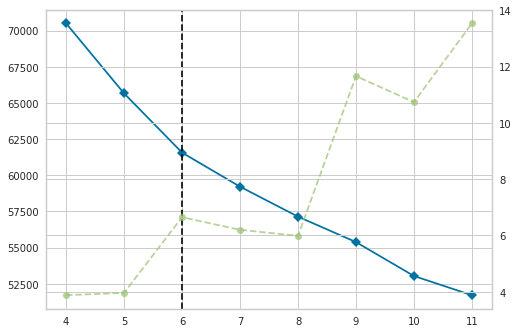

In [9]:
gmm = clustering.findCluster(X_train)
df_X_train = clustering.addClusterFeatures(gmm, X_train, columns)
df_X_val = clustering.addClusterFeatures(gmm, X_val, columns)

In [10]:
X = np.asarray(X_std)
X_train = np.asarray(df_X_train)
X_val = np.asarray(df_X_val)
y = np.asarray(y)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

Dump all processed data

In [11]:
joblib.dump(X, "../data/processed/X")
joblib.dump(X_train, "../data/processed/X_train")
joblib.dump(X_val, "../data/processed/X_val")
joblib.dump(y, "../data/processed/y")
joblib.dump(y_train, "../data/processed/y_train")
joblib.dump(y_val, "../data/processed/y_val")

['../data/processed/y_val']

## Feature Engineering - Stacking TP and TN prediction results

Simplified week 2 approach by justing adding two classifiers, and one is stronger in TP and another one is stronger in TN.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


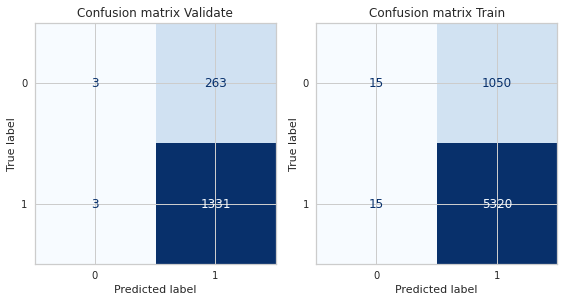

LogisticRegression(C=0.01, l1_ratio=0.3, penalty='elasticnet', solver='saga')


In [12]:
classifier_TP = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.3, C=0.01)
model_TP,TP_tr_auroc,TP_v_auroc = eval_model.eval_model(classifier_TP, X_train, y_train, X_val, y_val)

[23:30:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


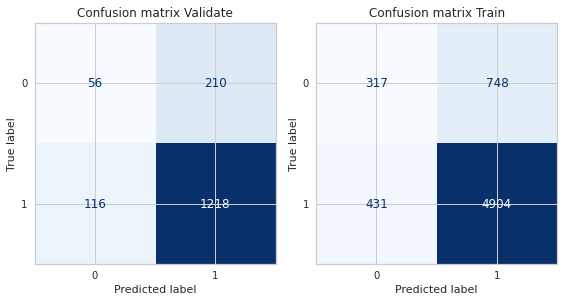

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.01,
                max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=0.4,
                tree_method='exact', validate_parameters=1, verbosity=None)


In [13]:
classifier_TN = xgb.XGBRFClassifier(max_depth=4, learning_rate=0.01, objective='binary:logistic', scale_pos_weight=0.4)
model_TN,TN_tr_auroc,TN_v_auroc = eval_model.eval_model(classifier_TN, X_train, y_train, X_val, y_val)

### Use the trained model to add the prediction probability as new features of TP and TN to both training set and validation set

In [14]:
df_PN_train = df_X_train
df_PN_train['TP'] = model_TP.predict_proba(X_train)[:,1]
df_PN_train['TN'] = model_TN.predict_proba(X_train)[:,1]
X_PN_train = np.asarray(df_PN_train)

In [15]:
df_PN_val = df_X_val
df_PN_val['TP'] = model_TP.predict_proba(X_val)[:,1]
df_PN_val['TN'] = model_TN.predict_proba(X_val)[:,1]
X_PN_val = np.asarray(df_PN_val)

## Experiment on all features plus TP and TN new features.

[23:31:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


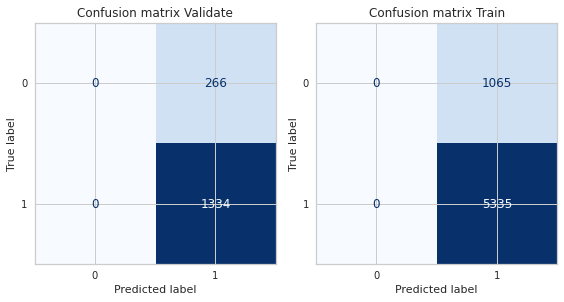

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.1, max_delta_step=0,
                max_depth=1, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=0.6,
                tree_method='exact', validate_parameters=1, verbosity=None)


In [16]:
classifier_stacking = xgb.XGBRFClassifier(max_depth=1, learning_rate=0.1, objective='binary:logistic', scale_pos_weight=0.6)
model_stacking,stacking_tr_auroc,stacking_v_auroc = eval_model.eval_model(classifier_stacking, X_PN_train, y_train, X_PN_val, y_val)

😔 **Result is not ideal as still no TN detected when hyperparameters are tuned to remove overfitting.**

## Experiment on using feature **cluster** to create different models and combine them
- The assumption here is that each group is naturally/factually closer to each other
- Running a classifier in each group shall achieve better performance in classification
- When it comes to validating, we use if else condition to determine which model to use

### Step 1 - Recalculate the clusters in training set and test set

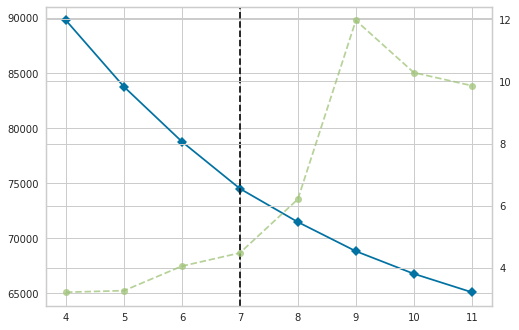

In [17]:
gmm = clustering.findCluster(X_std)
df_X_std = clustering.addClusterFeatures(gmm, X_std, columns)
X_std = np.asarray(df_X_std)
df_X_test = clustering.addClusterFeatures(gmm, X_test_std, columns)
X_test = np.asarray(df_X_test)

### Step 2 - Added in TP and TN prediction results

In [18]:
df_X_std.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,binned_GP,BadStats,cluster,distance_to_cluster_mean
0,1.006533,0.640574,0.123403,0.113959,0.047090,0.177269,-0.983145,-0.988278,0.101298,0.655953,0.760387,0.070227,1.428377,-0.121037,0.266040,1.161949,1.107242,-0.238596,0.473210,1.282505,-1.164297,2,4.009678
1,0.714265,0.360766,0.748626,0.822648,0.465578,1.704465,-0.265390,-0.102256,0.993652,1.087875,1.319370,-0.342956,3.210407,1.100107,1.608950,-0.681844,-0.364787,0.283247,0.196671,1.282505,-1.573360,3,3.132915
2,1.298800,0.058574,-0.640758,-0.535673,-0.482994,-0.293888,0.093488,0.150893,0.950123,-1.071732,-1.076272,0.416147,-0.608229,-0.264701,-0.405415,-0.608092,-0.610125,-0.238596,-0.909485,1.282505,0.471957,4,3.235899
3,0.012823,0.058574,0.216029,0.409246,0.130788,1.282049,-0.265390,-0.355405,0.181102,-0.531830,-0.357579,-0.429436,-0.353653,-0.121037,-0.117649,0.129425,-0.610125,-0.369057,0.888019,-0.044968,0.062894,5,2.400002
4,0.012823,-0.086926,-0.826009,-0.653788,-0.789885,1.005854,0.452365,0.404041,-0.544388,-1.287692,-1.156127,-1.668984,1.682952,0.381787,0.793612,-0.903099,-0.610125,0.283247,-0.771215,-0.044968,-0.346170,1,2.790837


In [19]:
model_TP = classifier_TP.fit(X_std, y)
model_TN = classifier_TN.fit(X_std, y)

[23:32:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
model_TN.feature_importances_

array([0.16448508, 0.02593355, 0.0571903 , 0.04952683, 0.01676058,
       0.03860266, 0.01299937, 0.0109242 , 0.01476033, 0.04867434,
       0.02163233, 0.01609443, 0.03251466, 0.02354828, 0.04241788,
       0.01561101, 0.0138845 , 0.01532825, 0.02998518, 0.20008647,
       0.11061283, 0.02158691, 0.01684009], dtype=float32)

In [21]:
df_PN_std = df_X_std
df_PN_std['TP'] = model_TP.predict_proba(X_std)[:,1]
df_PN_std['TN'] = model_TN.predict_proba(X_std)[:,1]
X_PN_std = np.asarray(df_PN_std)

In [22]:
df_PN_test = df_X_test
df_PN_test['TP'] = model_TP.predict_proba(X_test)[:,1]
df_PN_test['TN'] = model_TN.predict_proba(X_test)[:,1]
X_PN_test = np.asarray(df_PN_test)

In [23]:
df_PN_std['TARGET'] = y

### Step 1 - Train multiple classifiers based on cluster grouping

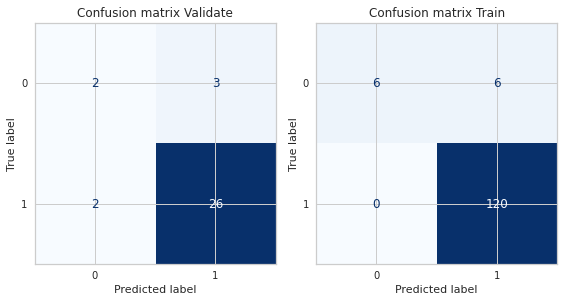

LogisticRegression(C=0.4, l1_ratio=0.7, penalty='elasticnet', solver='saga')


In [24]:
model_0 = eval_model.eval_model_with_df(LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.7, C=0.4), df_PN_std[df_PN_std['cluster']==0])

[23:32:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


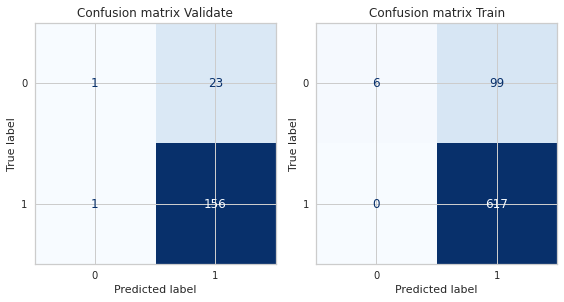

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=2,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=10, tree_method='exact', validate_parameters=1,
                verbosity=None)


In [25]:
model_1 = eval_model.eval_model_with_df(xgb.XGBRFClassifier(max_depth=2, learning_rate=1, scale_pos_weight=10,objective='binary:logistic'), df_PN_std[df_PN_std['cluster']==1])

[23:32:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


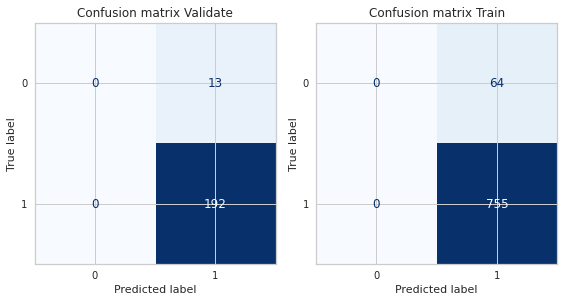

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.1, max_delta_step=0,
                max_depth=2, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=1.6,
                tree_method='exact', validate_parameters=1, verbosity=None)


In [26]:
model_2 = eval_model.eval_model_with_df(xgb.XGBRFClassifier(max_depth=2, learning_rate=0.1, scale_pos_weight=1.6,objective='binary:logistic'), df_PN_std[df_PN_std['cluster']==2])

[23:32:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


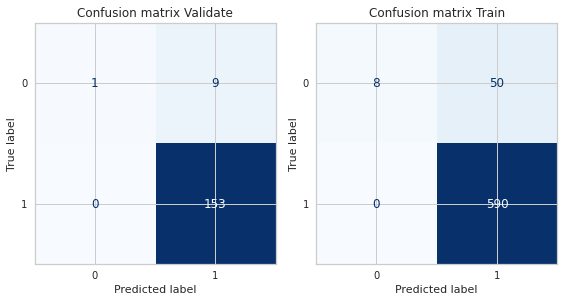

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=10, max_delta_step=0,
                max_depth=2, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=10,
                tree_method='exact', validate_parameters=1, verbosity=None)


In [27]:
model_3 = eval_model.eval_model_with_df(xgb.XGBRFClassifier(max_depth=2, learning_rate=10, scale_pos_weight=10,objective='binary:logistic'), df_PN_std[df_PN_std['cluster']==3])

[23:32:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


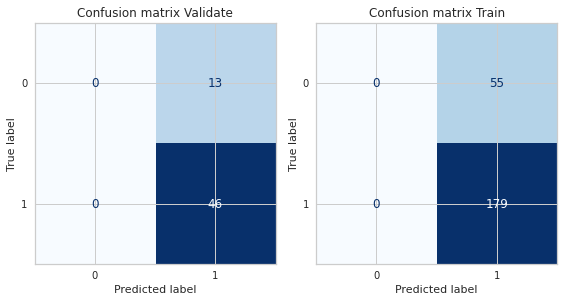

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=1,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=10, tree_method='exact', validate_parameters=1,
                verbosity=None)


In [28]:
model_4 = eval_model.eval_model_with_df(xgb.XGBRFClassifier(max_depth=1, learning_rate=1, scale_pos_weight=10,objective='binary:logistic'), df_PN_std[df_PN_std['cluster']==4])

[23:32:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


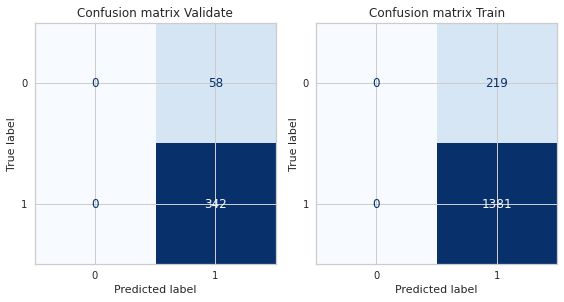

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=9, max_delta_step=0,
                max_depth=2, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=3,
                tree_method='exact', validate_parameters=1, verbosity=None)


In [29]:
model_5 = eval_model.eval_model_with_df(xgb.XGBRFClassifier(max_depth=2, learning_rate=9, scale_pos_weight=3,objective='binary:logistic'), df_PN_std[df_PN_std['cluster']==5])

[23:32:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


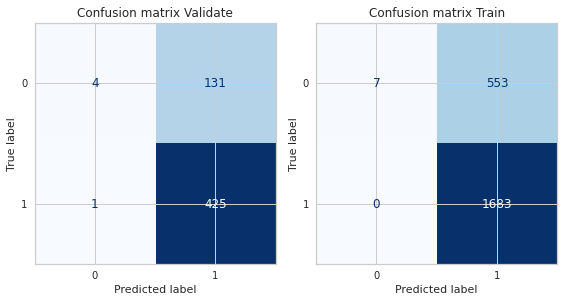

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=10, tree_method='exact', validate_parameters=1,
                verbosity=None)


In [30]:
model_6 = eval_model.eval_model_with_df(xgb.XGBRFClassifier(max_depth=3, learning_rate=1, scale_pos_weight=10,objective='binary:logistic'), df_PN_std[df_PN_std['cluster']==6])

### Step 2 - Combined and use the cluster driven models

In [31]:
clfs = [model_0,model_1,model_2,model_3,model_4,model_5,model_6]

In [32]:
def combineClfs(df, clfs):
    y_clfs = np.ones(df.shape[0])
    for counter in range(df.shape[0]):
        cluster = int((df.loc[counter])['cluster'])
        model = clfs[cluster]
        X_clfs = np.asarray(df.loc[counter])
        X_clfs = X_clfs.reshape(1,25)
        y_clfs[counter] = model.predict_proba(X_clfs)[0,1]
    return y_clfs

In [33]:
df_clfs = df_PN_std
y_clfs = df_clfs.pop('TARGET')
y_pred_clfs = combineClfs(df_clfs,clfs)
roc_auc_score(y, y_pred_clfs)

0.6203032544920323

In [34]:
from numpy import vectorize
vfunc = vectorize(lambda x: 1 if x >= 0.5 else 0)
confusion_matrix(y, vfunc(y_pred_clfs))

array([[  35, 1296],
       [   4, 6665]])

**This result is really disappointing, and it's actually the combination from all models created above. Even though each model's performance seem okay, but the combined one is a lot worse due to the inability to identify TN**